In [4]:
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
import vector
print("awkward version ", ak.__version__)
print("coffea version ", coffea.__version__)
print("numpy version ", np.__version__)
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from collections import defaultdict
import pickle
from distributed.diagnostics.plugin import UploadDirectory
import os
from plot_utils import adjust_plot
import matplotlib.pyplot as plt
from utils import Histfit
import correctionlib
from scipy.optimize import curve_fit

from distributed.diagnostics.plugin import UploadDirectory
import mplhep as hep
hep.style.use("CMS")


awkward version  1.10.3
coffea version  0.7.21
numpy version  1.23.5


In [5]:
from qcd_processor_lib import QCDProcessor
from qcd_processor_runner import runner
from processor_utils import *

In [6]:
%load_ext autoreload

%autoreload 2

In [42]:
# from dask.distributed import Client

# client = Client("tls://localhost:8786")
# #client = None

/opt/conda/lib/python3.8/site-packages/distributed/client.py:1288: VersionMismatchWarning: Mismatched versions found

+---------+----------------+----------------+----------------+
| Package | client         | scheduler      | workers        |
+---------+----------------+----------------+----------------+
| python  | 3.8.16.final.0 | 3.8.16.final.0 | 3.8.15.final.0 |
+---------+----------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [14]:
from distributed import Client
from lpcjobqueue import LPCCondorCluster

cluster = LPCCondorCluster(transfer_input_files = ["data","samples", "qcd_processor_lib.py","qcd_processor_runner.py", "smp_utils.py", "utils.py","processor_utils.py","plot_utils.py"], ship_env = True)
cluster.adapt(minimum=0, maximum=10000)
client = Client(cluster)

print(client.run(os.listdir) )
client.scheduler_info()['workers']

/opt/conda/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45406 instead
  warnings.warn(


{}


{}

In [15]:
import mplhep as hep
hep.style.use("CMS")
plt.rcParams['figure.dpi'] = 60

In [19]:
# Set era here
#year = 2017
eras = ["2017"]
testing = False

In [21]:
eraslist = [ ["2017"]]
for eras in eraslist:
    hists = runner(testing = testing, eras = eras, prependstr = "root://cmsxrootd.fnal.gov/", nworkers = 4, client = client  )
    if testing == True:
        fname_out = 'test_QCD_pt_response_'+eras[0]+'JME'+'.pkl'
    else:
        fname_out = 'QCD_pt_response_'+eras[0]+'JME'+'.pkl'

    with open(fname_out, "wb") as f:
            pickle.dump( hists, f )

    print(f"The histograms are stored in {fname_out}")

[####                                    ] | 10% Completed |  1min 49.8ss

Failed to commit and disconnect from queue.


[#########                               ] | 24% Completed |  3min  0.7s

Task exception was never retrieved
future: <Task finished name='Task-341808' coro=<_wrap_awaitable() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:118> exception=AssertionError()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 119, in _wrap_awaitable
    return await aw
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 69, in _
    assert self.status == Status.running
AssertionError


The histograms are stored in QCD_pt_response_2017JME.pklted |  7min 17.4s


In [ ]:
if testing == True:
    fname_out = 'test_QCD_pt_response_'+era+'JME'+'.pkl'
else:
    fname_out = 'QCD_pt_response_'+era+'JME'+'.pkl'

with open(fname_out, "wb") as f:
        pickle.dump( hists, f )
        
print(f"The histograms are stored in {fname_out}")

In [ ]:
hists["pt_reco_over_gen"].project("frac").plot(density= True)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f0a40a448b0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

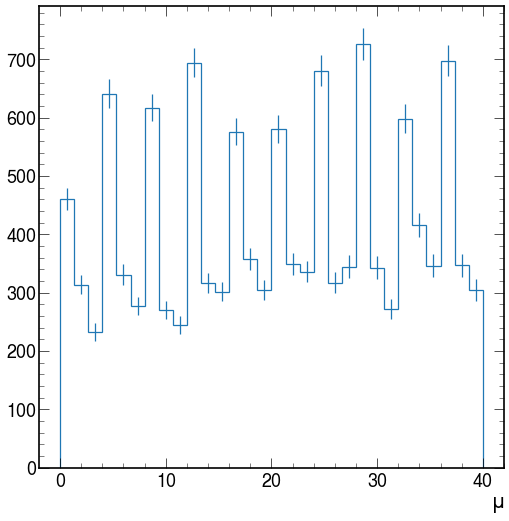

In [38]:
hists["pileup_rho"].project("pileup_fine").plot()

In [12]:
GetPUSF('2017', np.array(30))

array(1.00782377)

In [13]:
def mean_finder(hist, centers):
    sum = 0
    weight_sum = 0
    
    for i in range(len(hist)):
        sum = sum + hist[i]*centers[i]
        weight_sum = weight_sum + hist[i]
    return sum/weight_sum

def std_finder(hist, centers):
    sum = 0
    weight_sum = 0
    mean = mean_finder(hist, centers)
    
    for i in range(len(hist)):
        sum = sum + hist[i]*((centers[i] - mean)**2)
        weight_sum = weight_sum + hist[i]
        
    return np.sqrt(sum/(weight_sum - 1))

def sem_finder(hist, centers):
    return std_finder(hist,centers)/(np.sum(hist)**0.5)

def qdline(x, a, b, c):
    return a*x*x + b*x + c

In [14]:

with open("QCD_pt_response_2017JME.pkl", "rb") as f:
    output = pickle.load( f )

In [15]:
hist_1 = output["pileup_rho"]
pileup_centers = hist_1.axes[1].centers
pileup_bins = hist_1.axes[1].edges
pileup_widths = hist_1.axes[1].widths

rho_centers = hist_1.axes[2].centers
rho_widths = hist_1.axes[2].widths

In [16]:
hist_pileup_rho = hist_1.project("pileup_fine", "rho_fine")
hist_pileup_rho = hist_pileup_rho.to_numpy()[0]

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

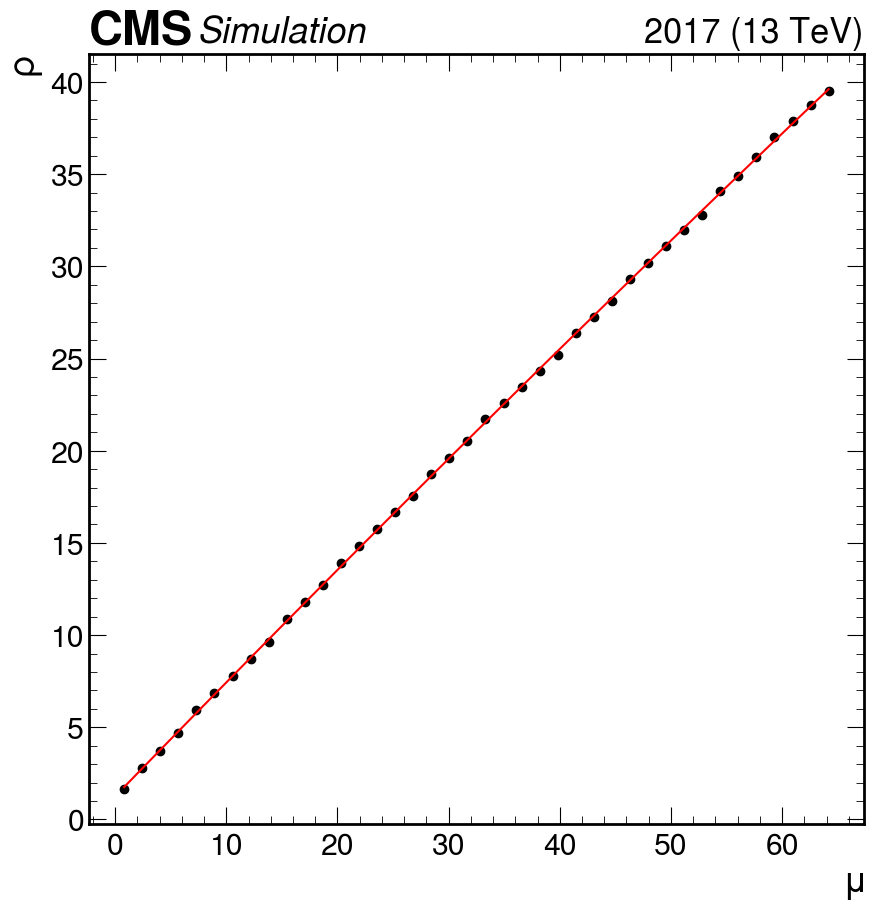

In [17]:
means = []
for i in range(len(hist_pileup_rho)):
    means.append(mean_finder(hist_pileup_rho[i], rho_centers))
    
plt.plot(pileup_centers, means, linestyle = "", marker = 'o', color = 'black')
popt, pcov = curve_fit(qdline, pileup_centers, means)
plt.plot(pileup_centers, qdline(pileup_centers, *popt), label = 'Fit', color = 'r')
plt.xlabel(r"$\mu$")
plt.ylabel(r"$\rho$")
hep.cms.label(year = 2017)

IndexError: index -1 is out of bounds for axis 0 with size 0

In [38]:
hist.axis.Regular(61, -.5, 60.5, name = 'pileup_fine', label = r"$\mu$").edges

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5,
       21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5,
       32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5,
       43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5,
       54.5, 55.5, 56.5, 57.5, 58.5, 59.5, 60.5])

In [20]:
m[/a

[1.647230738114421,
 2.79316564727642,
 3.7215877635481704,
 4.670064465952031,
 5.919463818947259,
 6.846246846726247,
 7.771378029780641,
 8.694383783927295,
 9.61919531002097,
 10.85732841530387,
 11.787219440161527,
 12.709826721143264,
 13.92172608441606,
 14.853298648855477,
 15.740788784098877,
 16.658504740876946,
 17.548378611713186,
 18.73854533475517,
 19.62995516468529,
 20.51734384869788,
 21.704531896610607,
 22.58919619334308,
 23.47062598759158,
 24.33880181180454,
 25.2167404762993,
 26.383807001995578,
 27.24622563320339,
 28.13683696507122,
 29.292501239495472,
 30.190557644185695,
 31.12101296322408,
 31.97069458755708,
 32.78052423992046,
 34.08535475784264,
 34.912309170602555,
 35.93665309593618,
 36.98836417517661,
 37.88446480075481,
 38.7501134149475,
 39.49503043891197]